In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy
from scipy.optimize import minimize

import tqdm as tq
from tqdm.notebook import tqdm

for pkg in [np, pd, matplotlib, scipy, tq]:
    print(pkg.__name__, pkg.__version__)

numpy 1.24.4
pandas 2.1.4
matplotlib 3.6.2
scipy 1.11.4
tqdm 4.66.1


In [2]:
# Where to save
curpathout = '.'
# Where to get input data
df = pd.read_csv('{}/Unfolding.csv'.format(curpathout))
df['Temperature'] = df['Temperature'].astype(int).astype('category')

  0%|          | 0/234 [00:00<?, ?it/s]

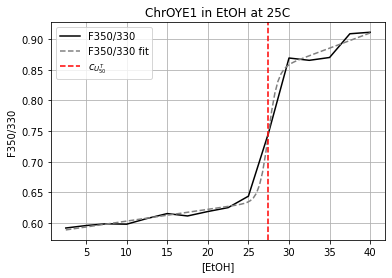

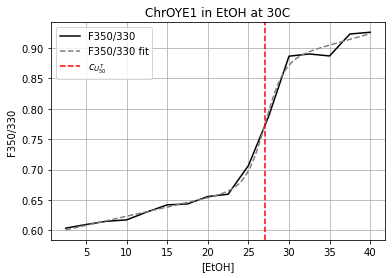

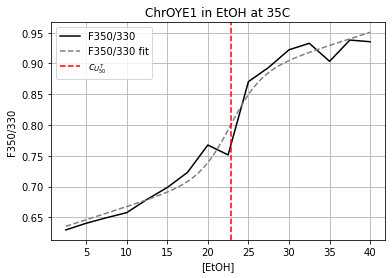

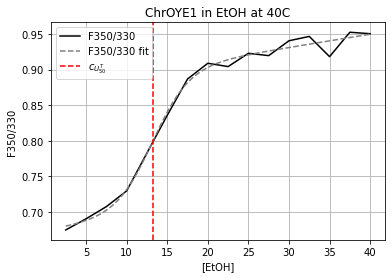

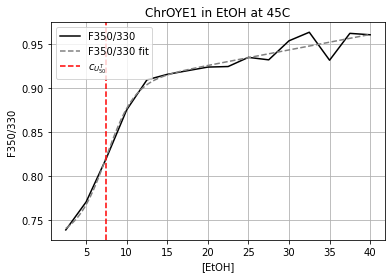

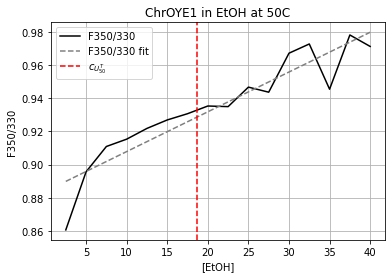

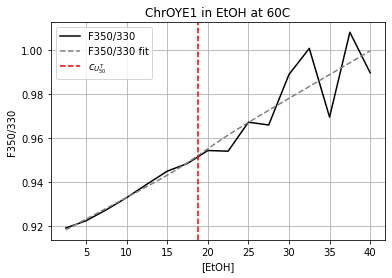

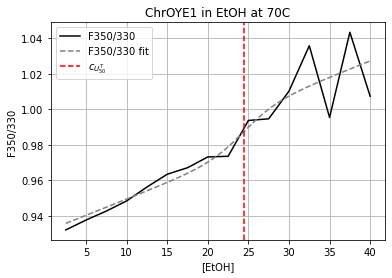

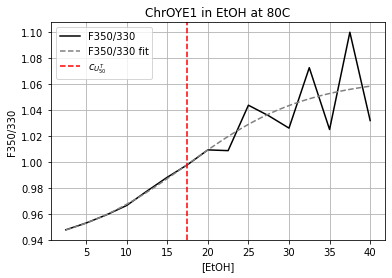

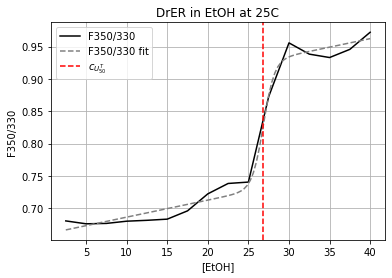

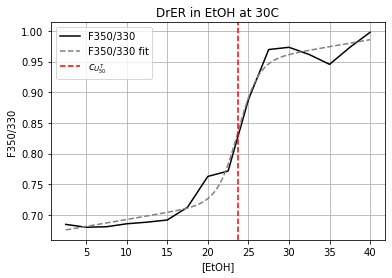

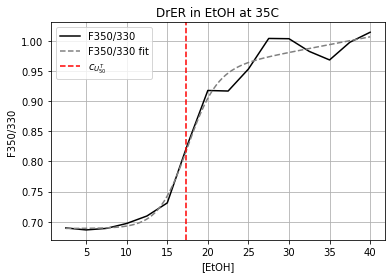

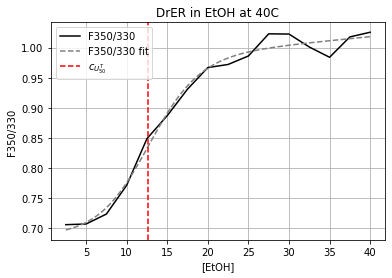

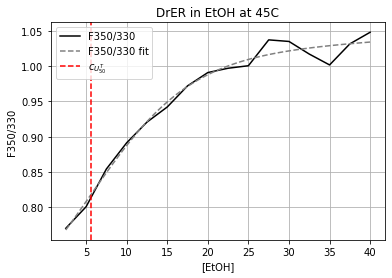

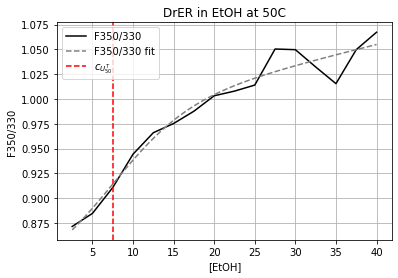

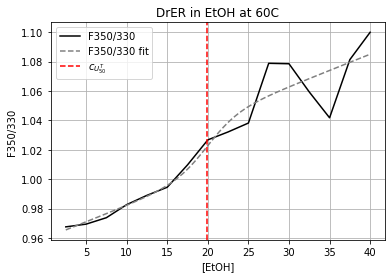

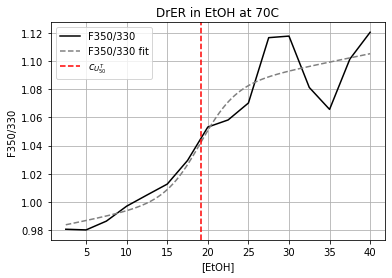

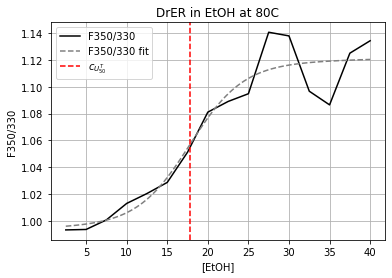

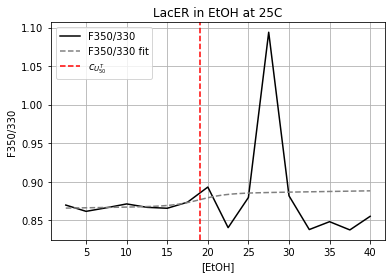

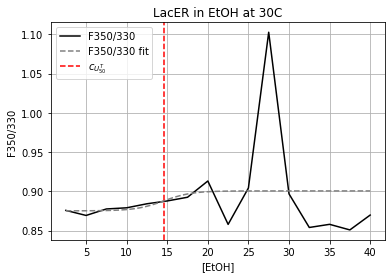

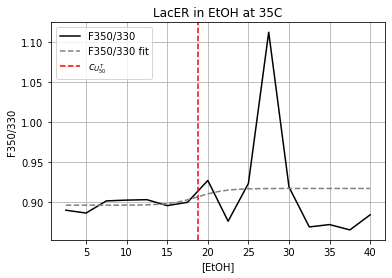

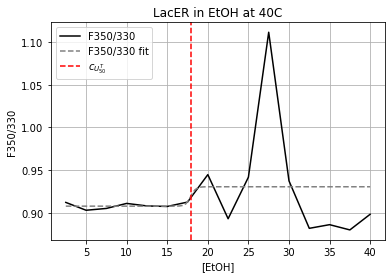

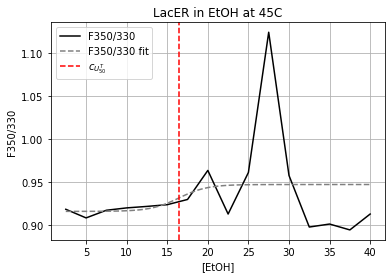

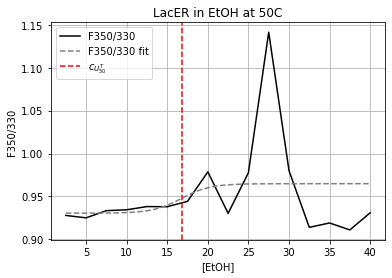

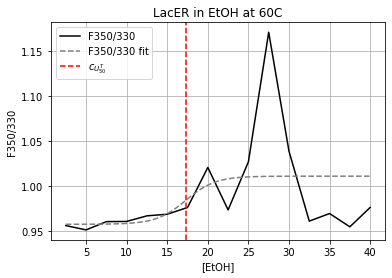

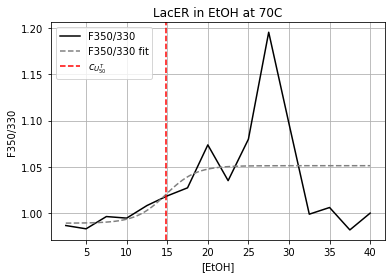

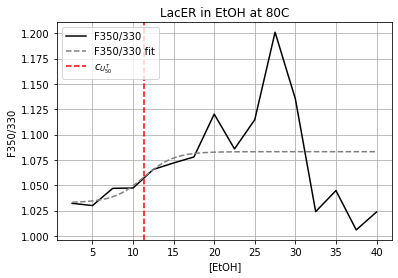

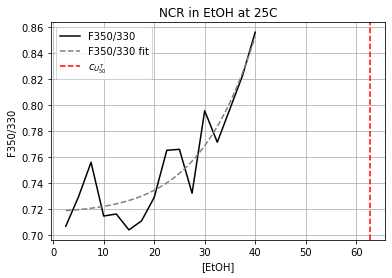

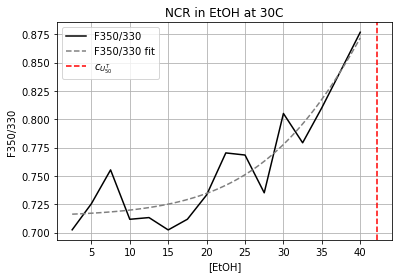

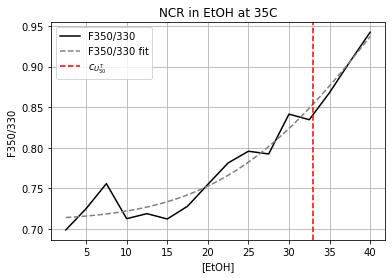

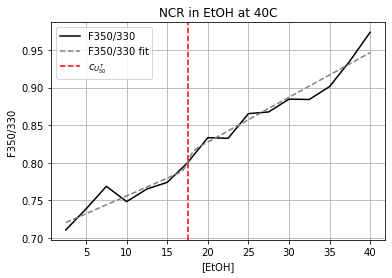

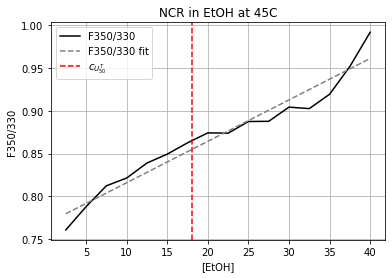

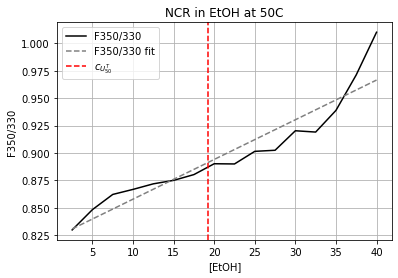

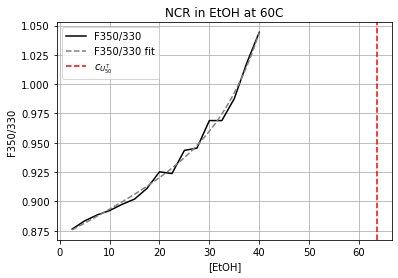

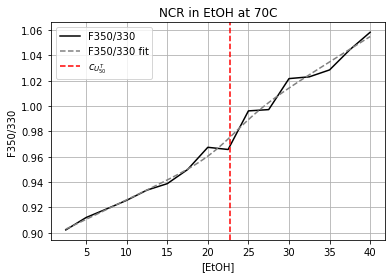

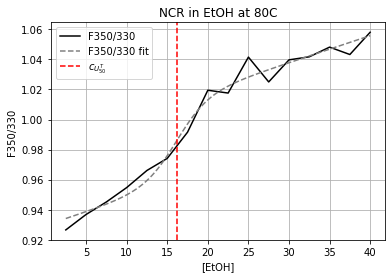

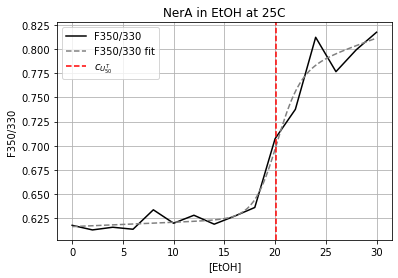

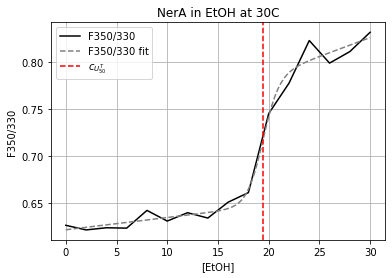

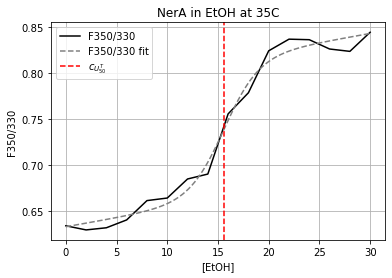

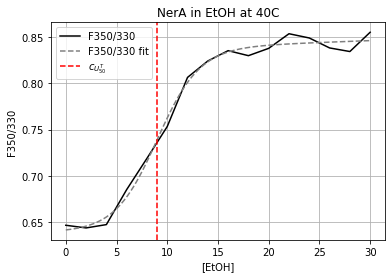

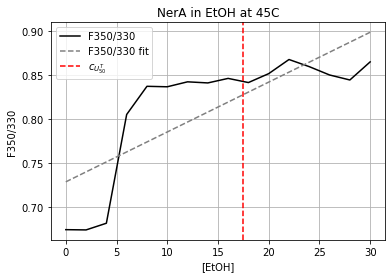

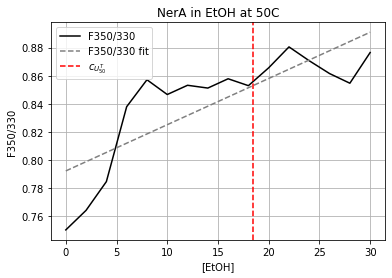

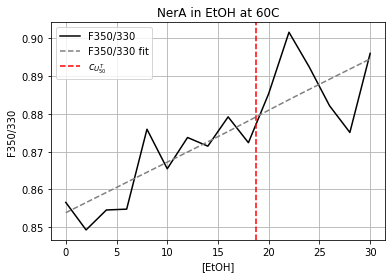

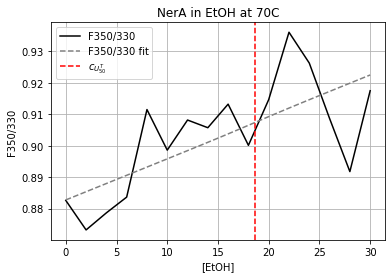

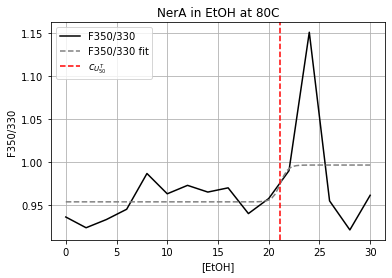

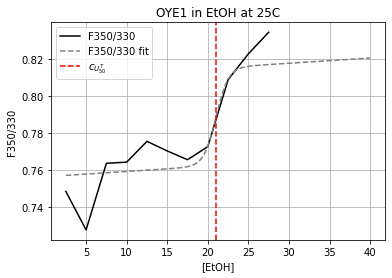

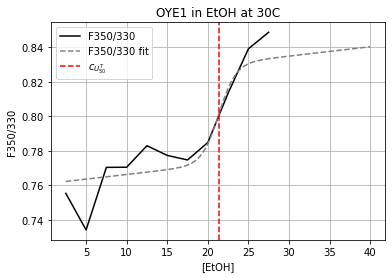

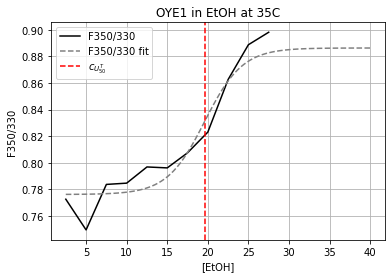

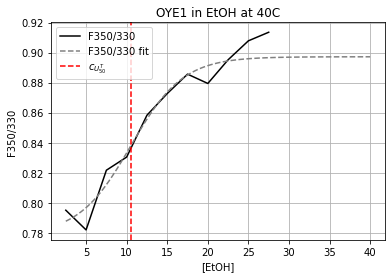

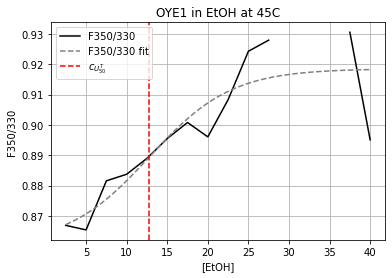

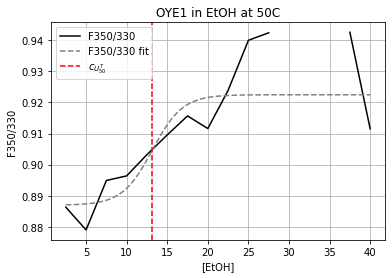

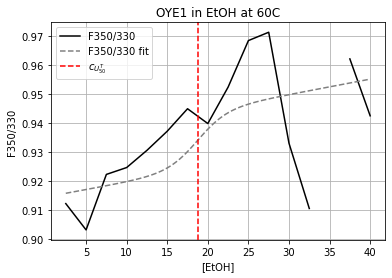

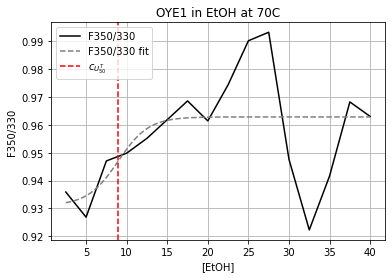

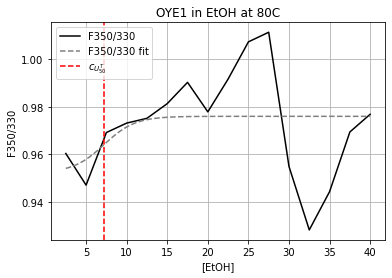

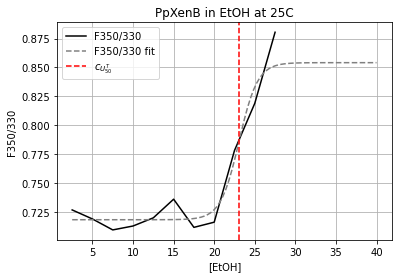

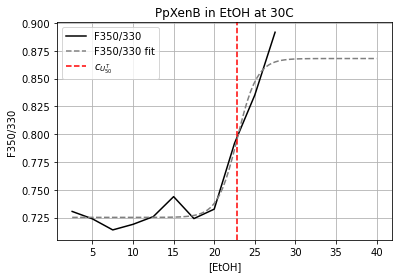

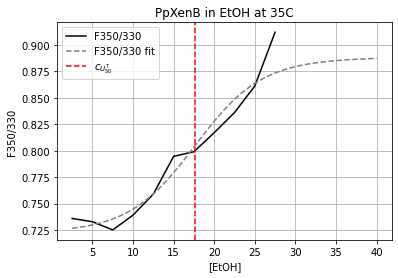

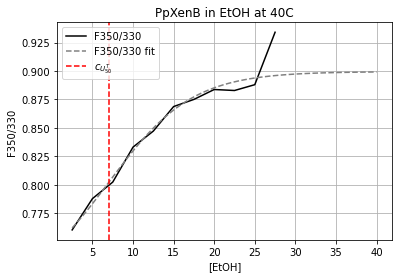

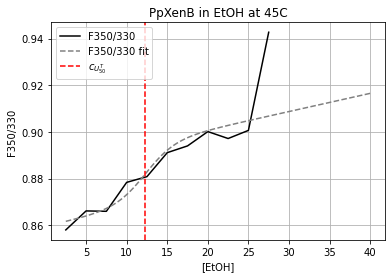

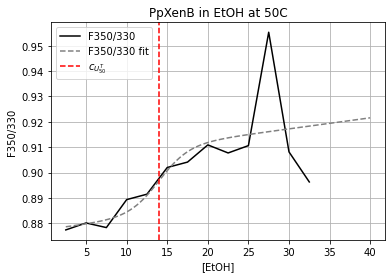

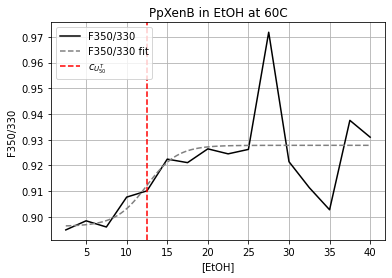

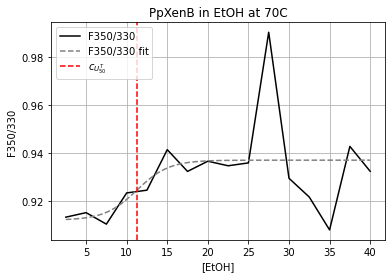

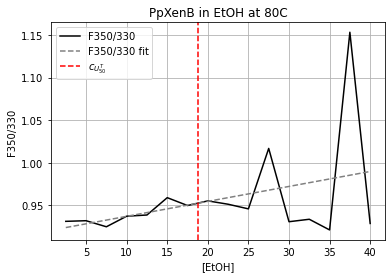

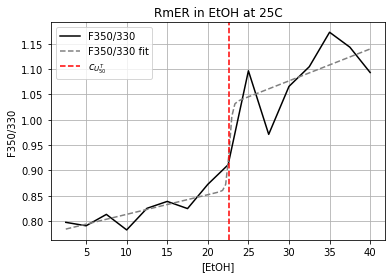

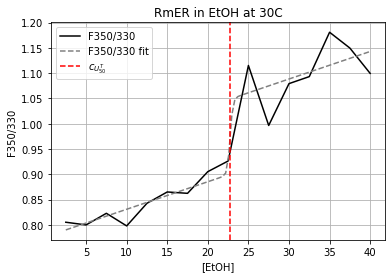

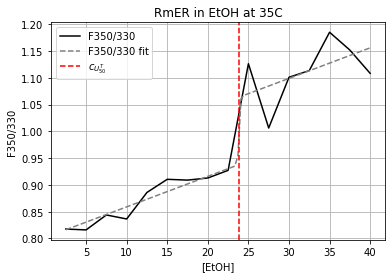

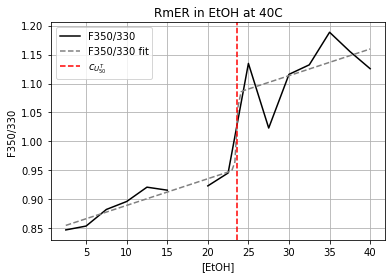

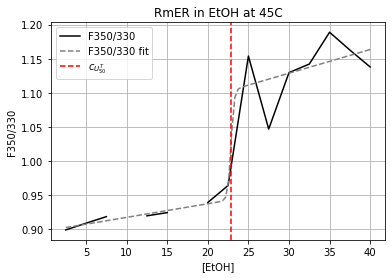

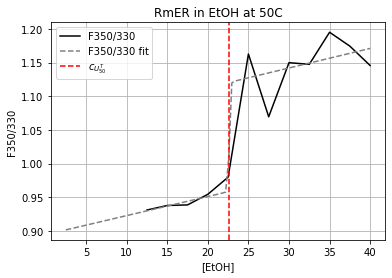

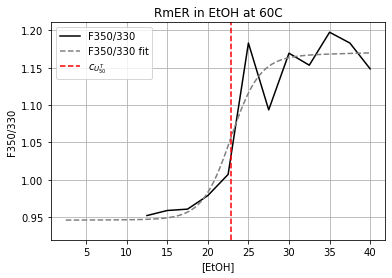

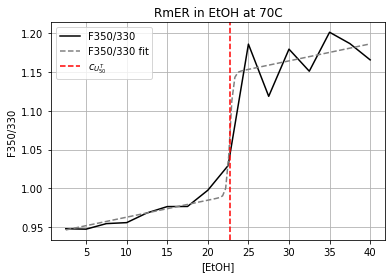

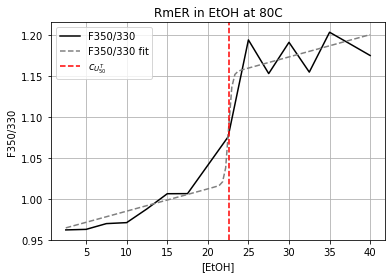

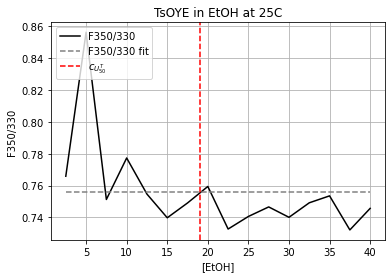

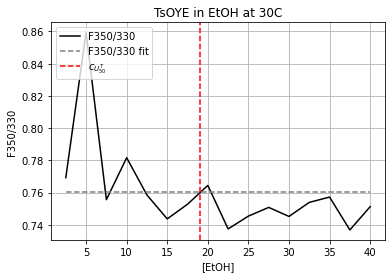

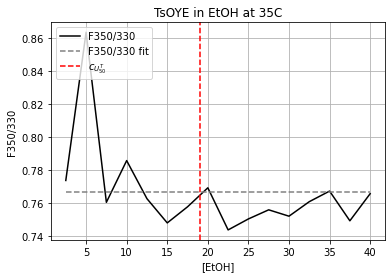

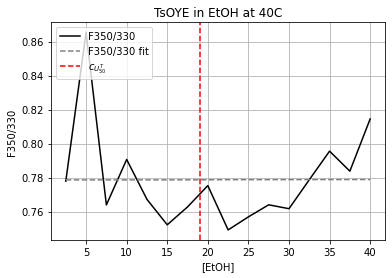

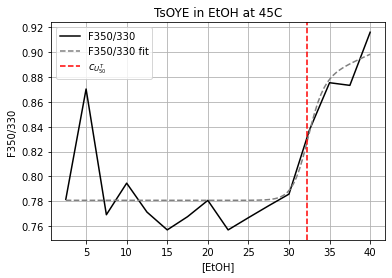

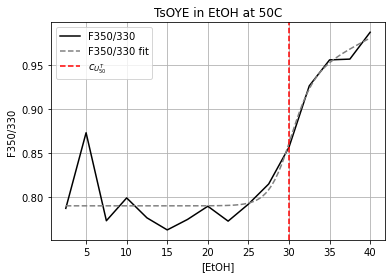

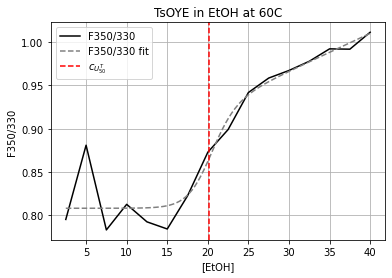

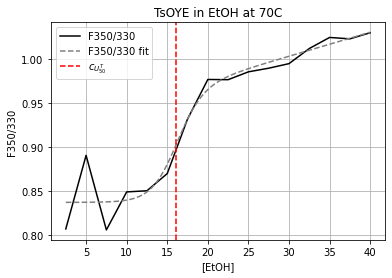

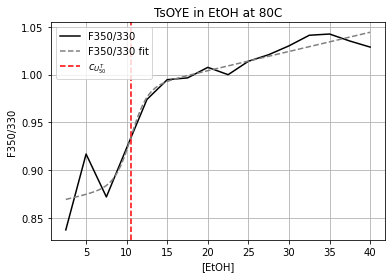

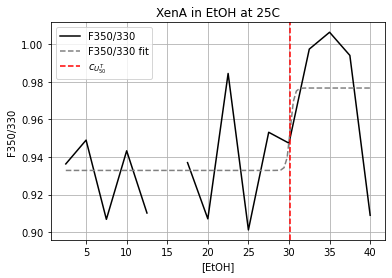

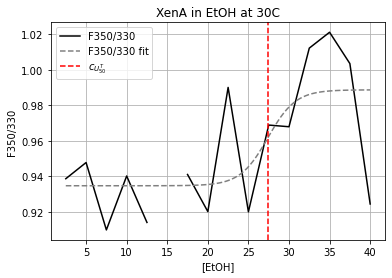

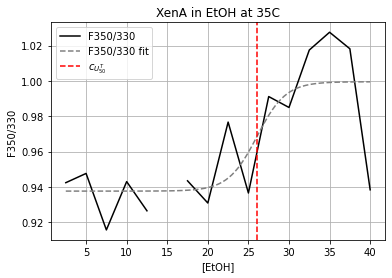

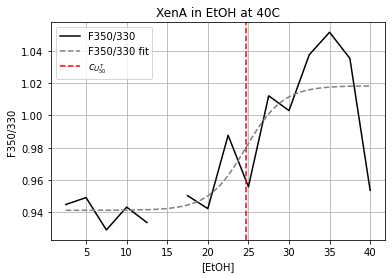

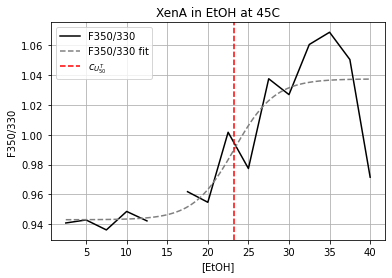

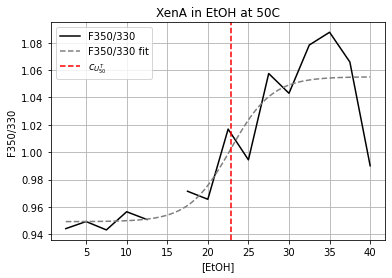

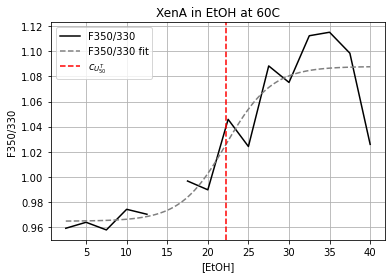

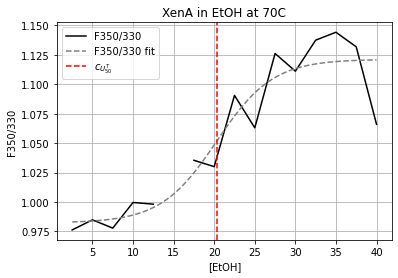

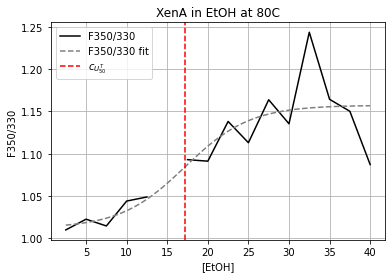

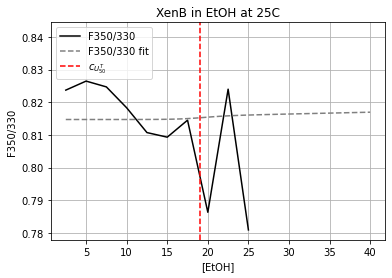

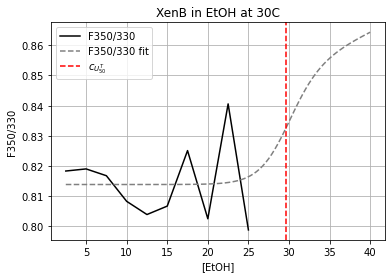

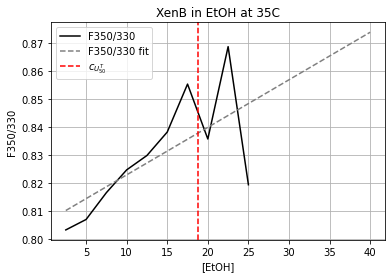

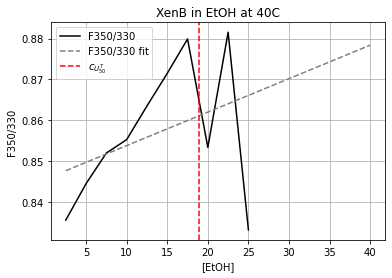

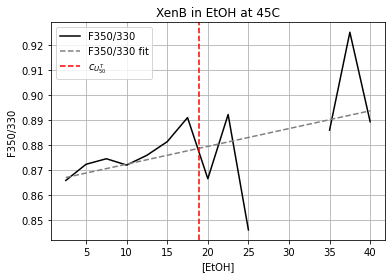

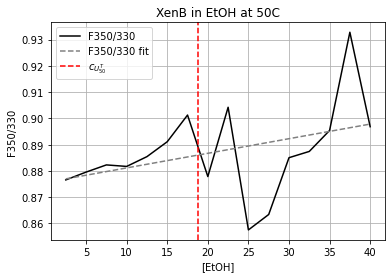

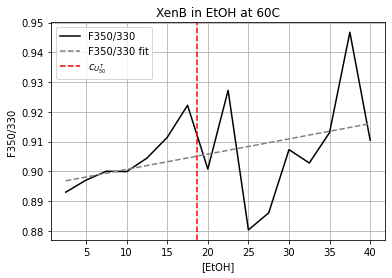

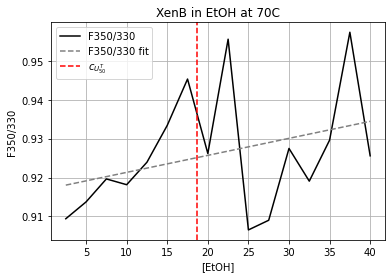

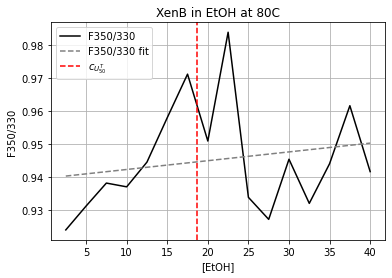

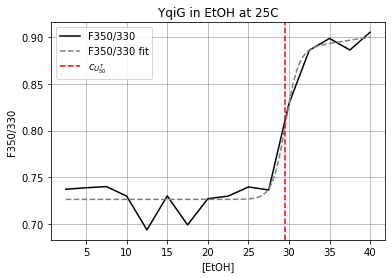

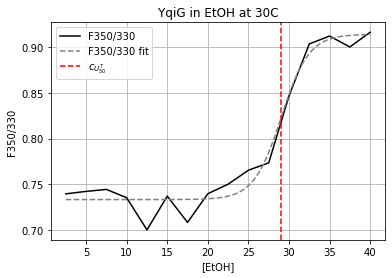

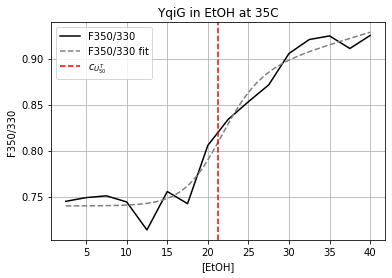

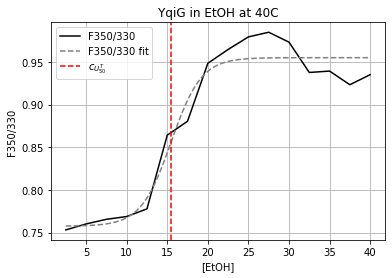

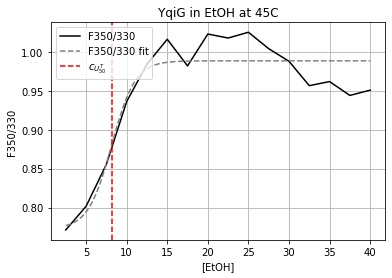

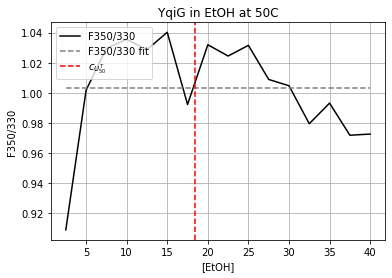

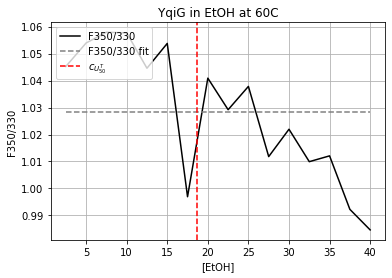

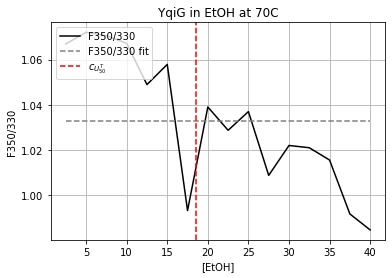

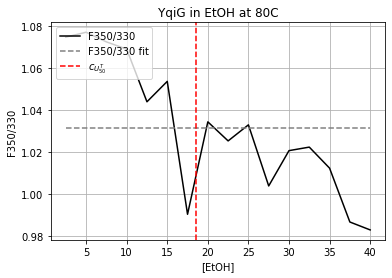

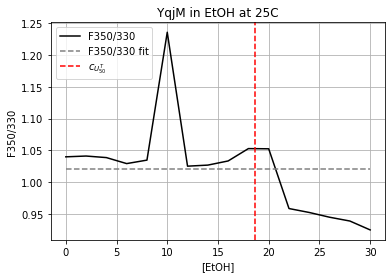

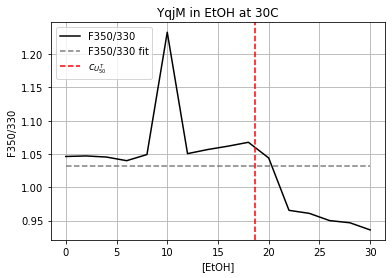

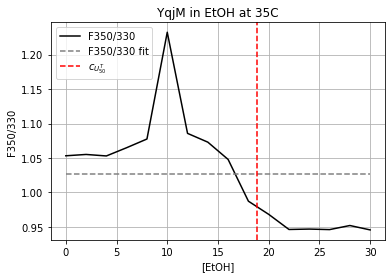

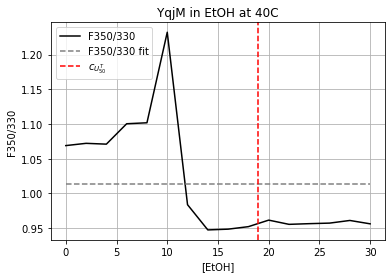

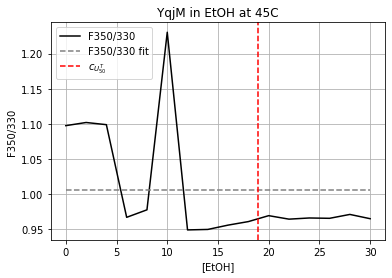

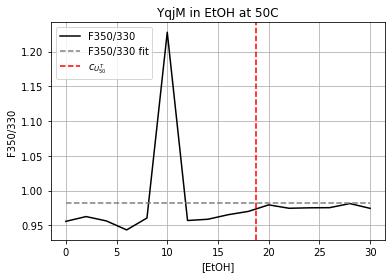

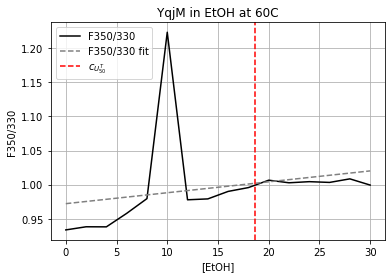

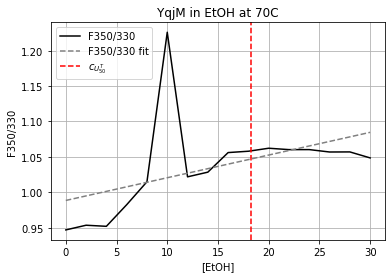

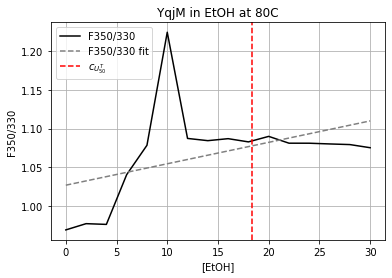

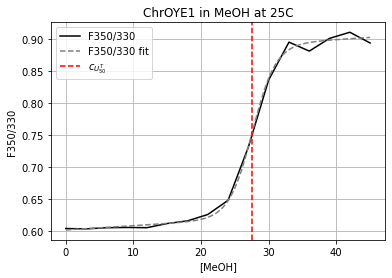

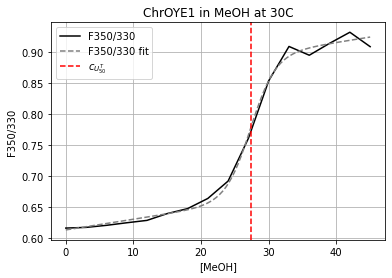

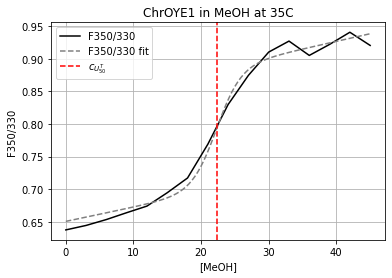

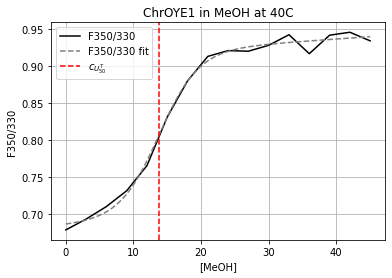

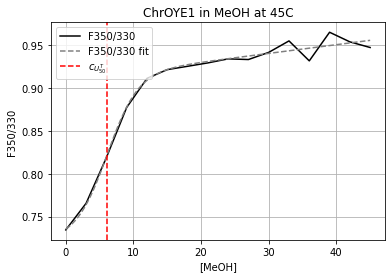

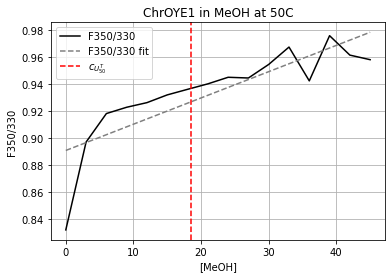

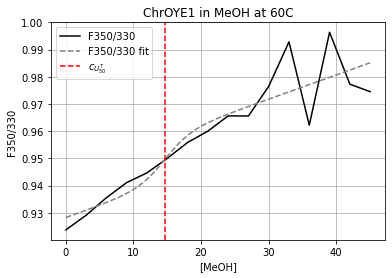

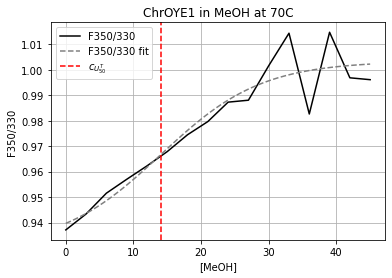

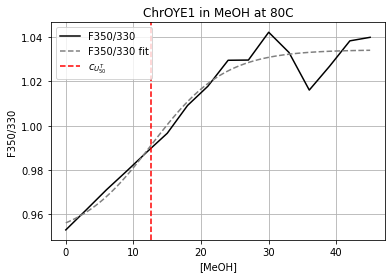

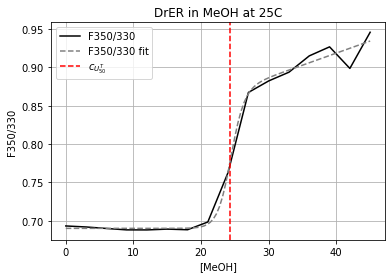

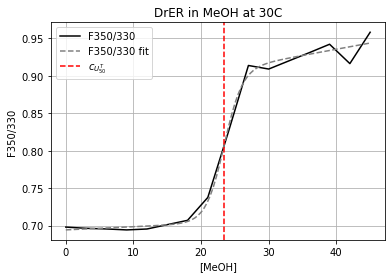

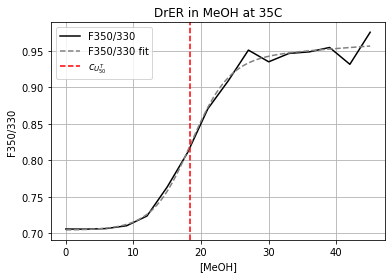

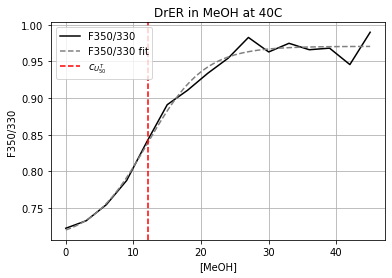

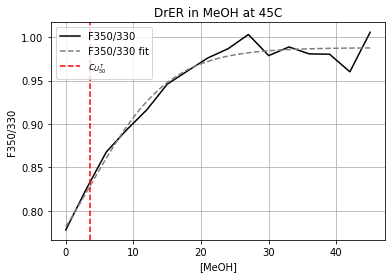

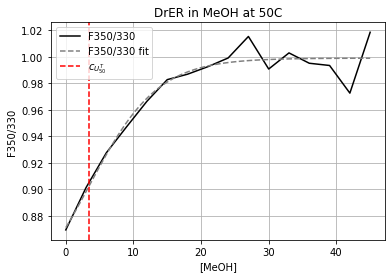

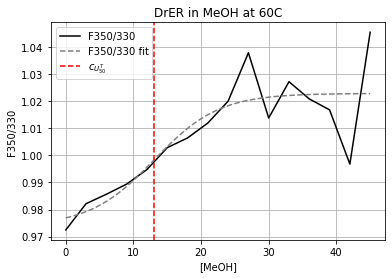

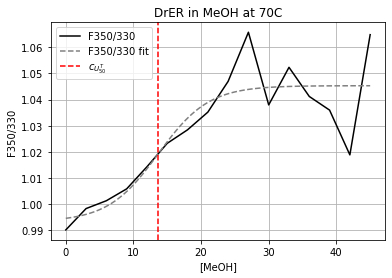

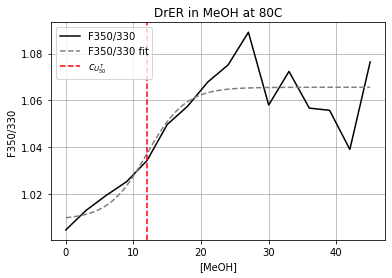

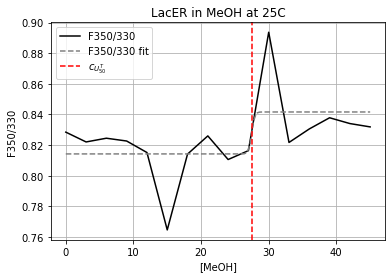

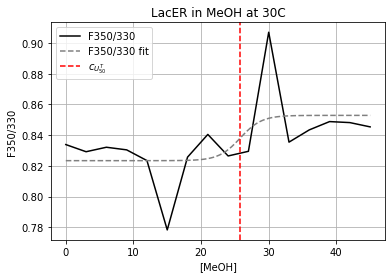

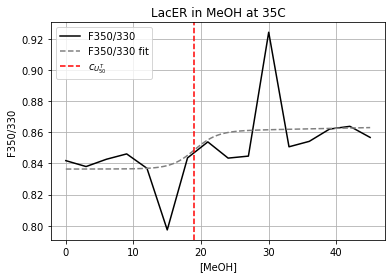

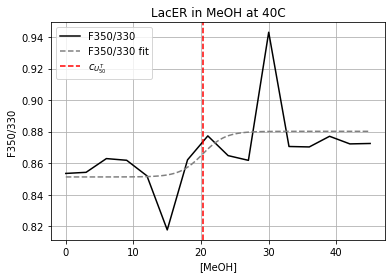

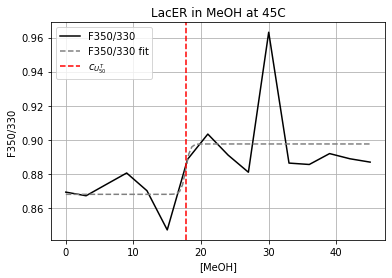

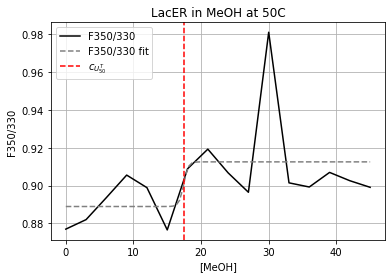

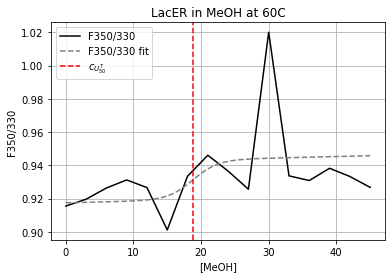

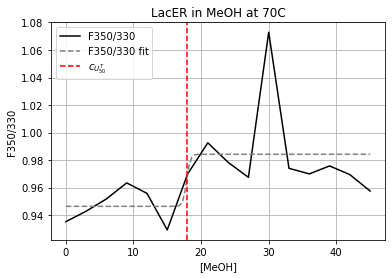

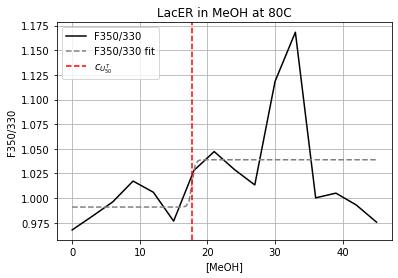

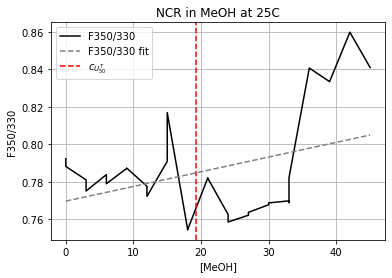

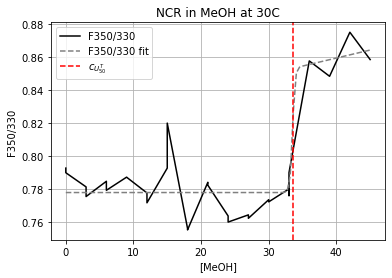

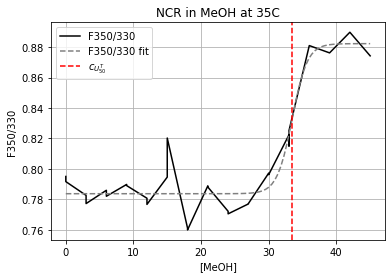

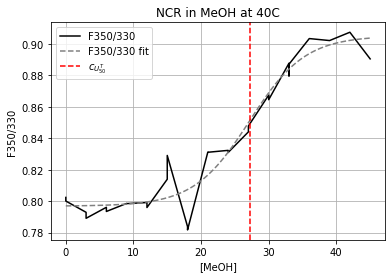

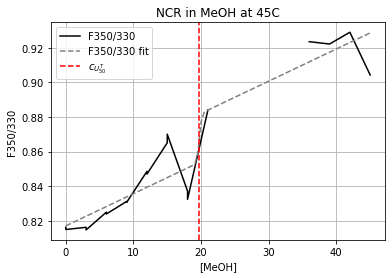

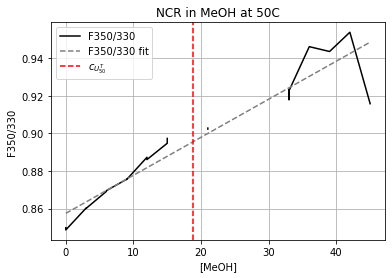

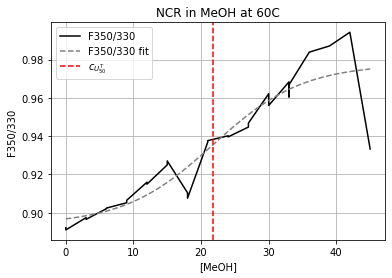

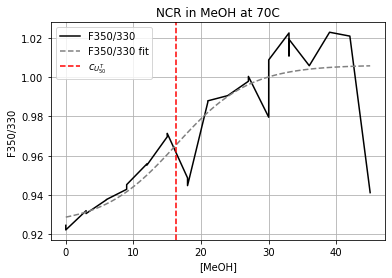

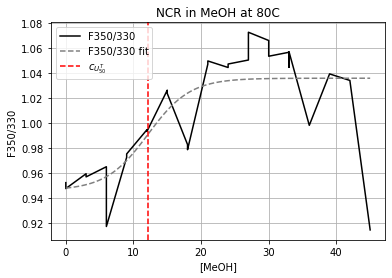

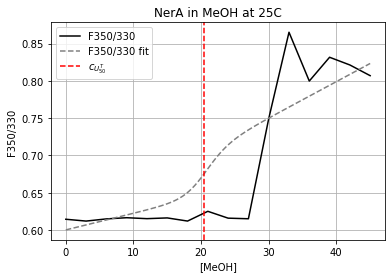

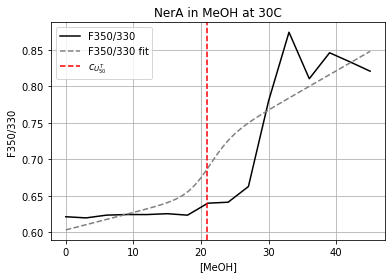

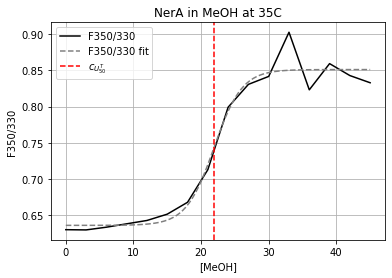

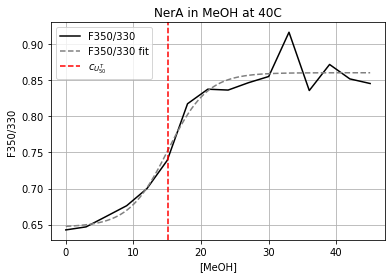

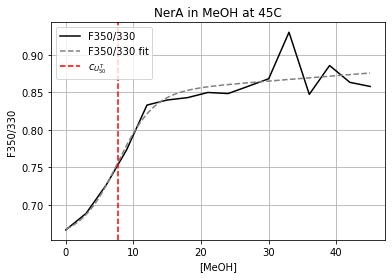

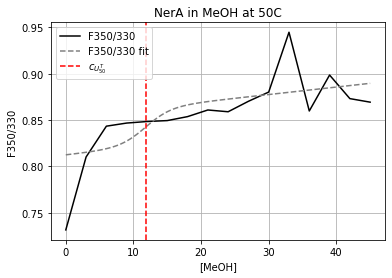

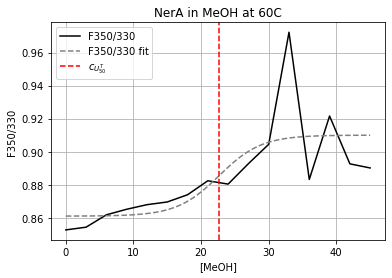

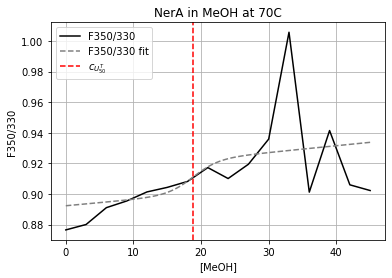

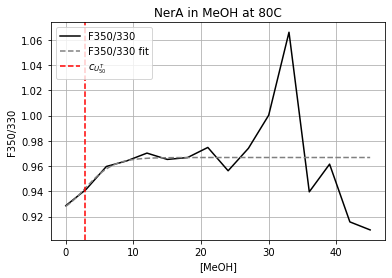

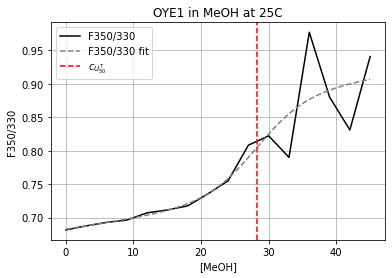

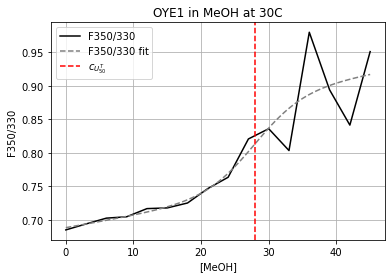

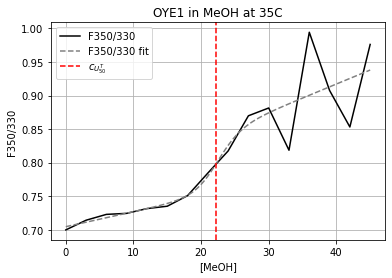

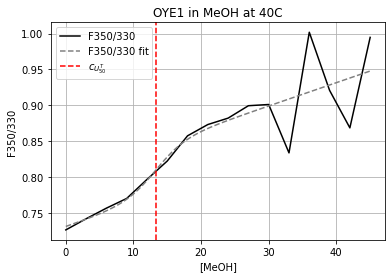

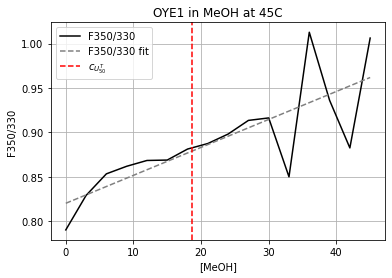

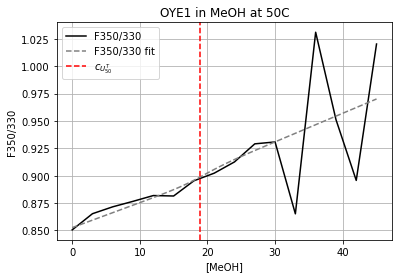

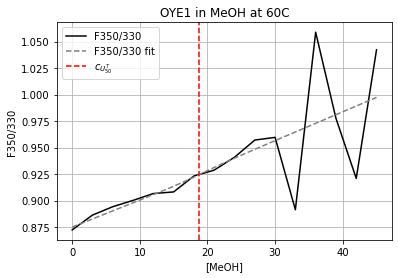

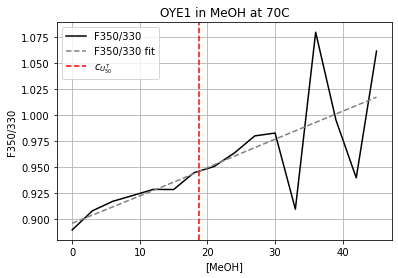

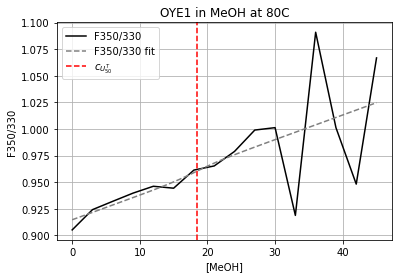

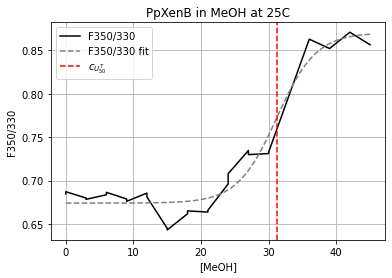

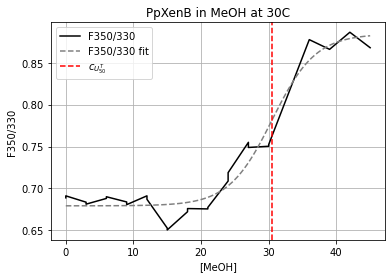

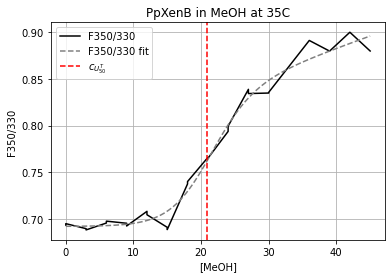

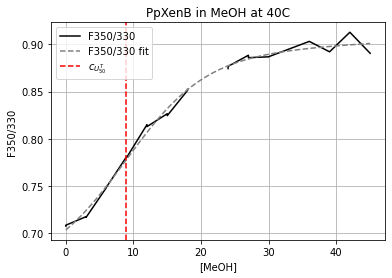

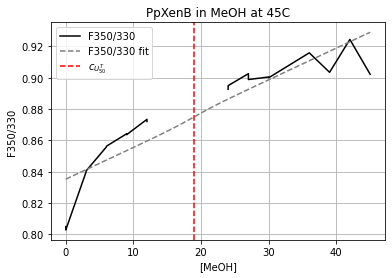

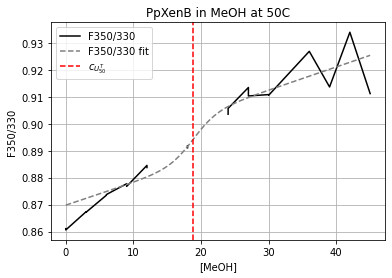

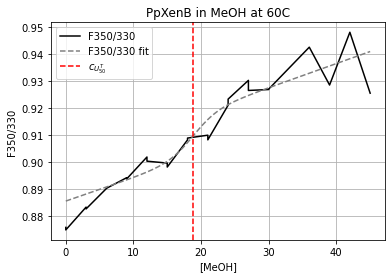

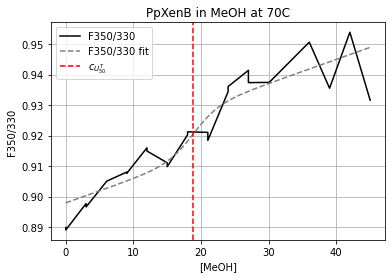

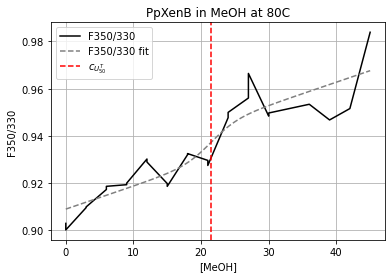

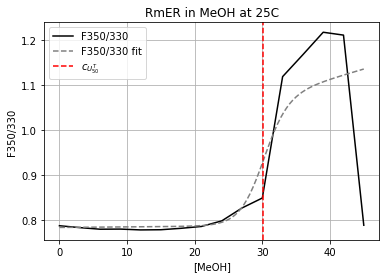

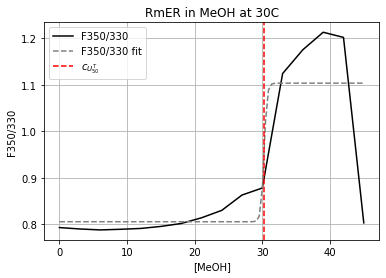

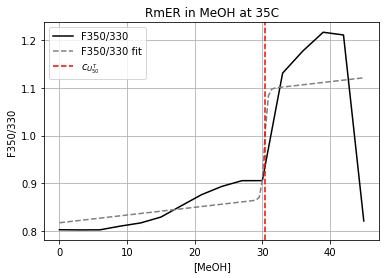

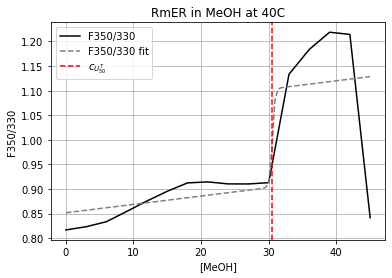

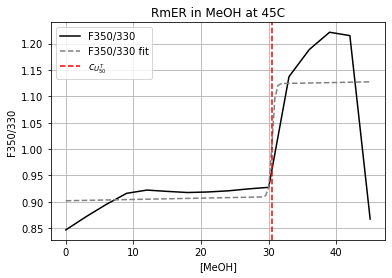

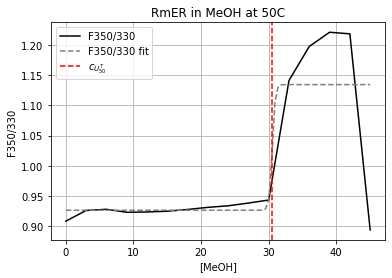

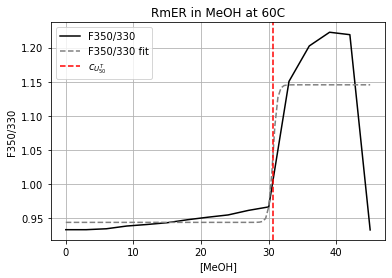

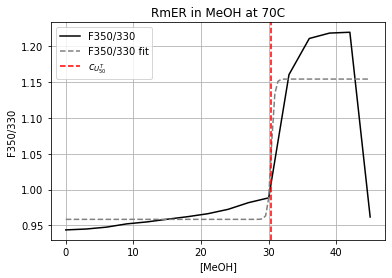

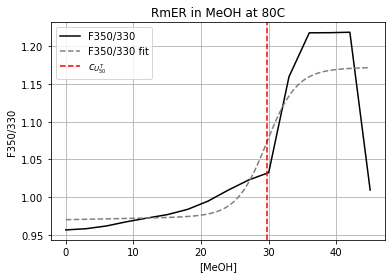

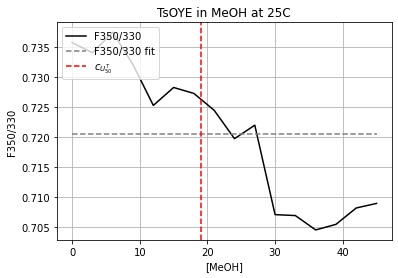

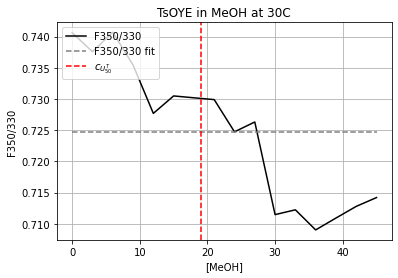

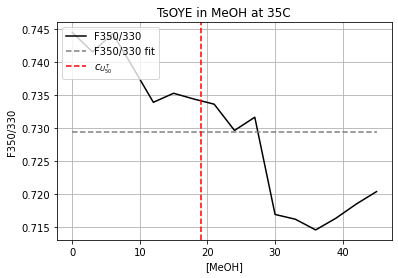

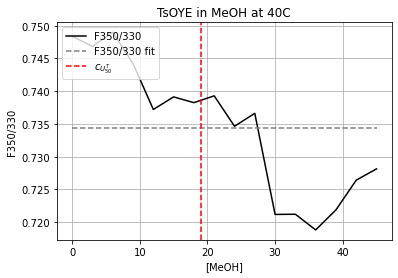

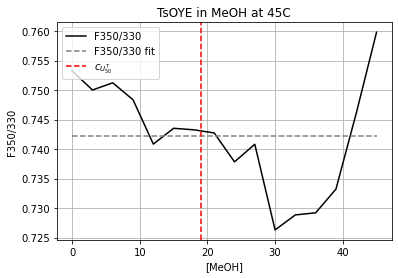

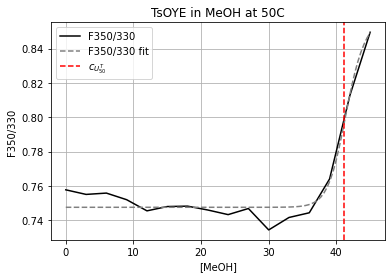

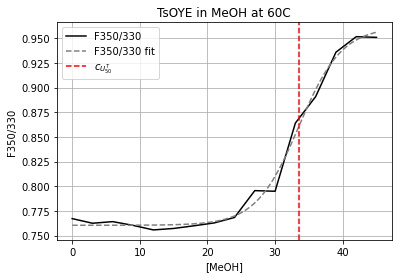

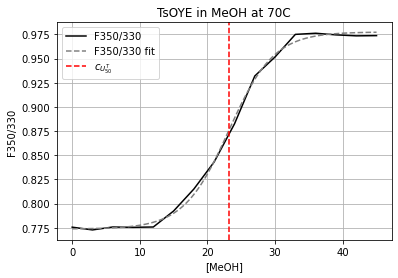

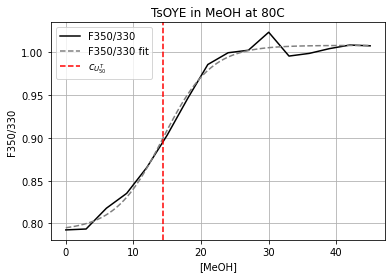

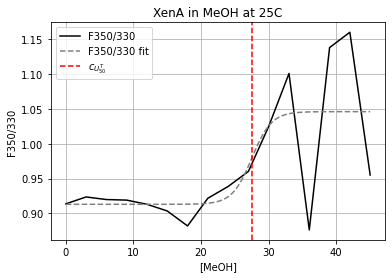

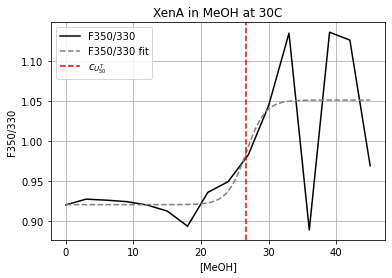

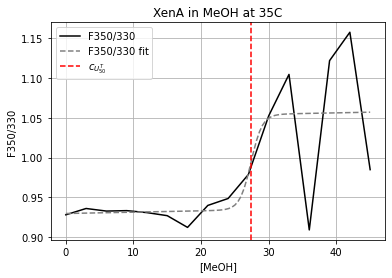

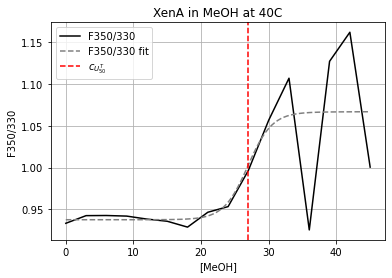

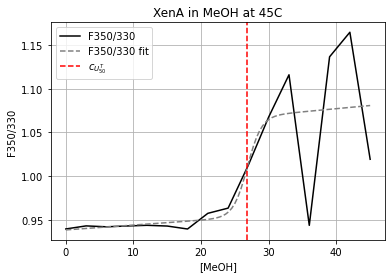

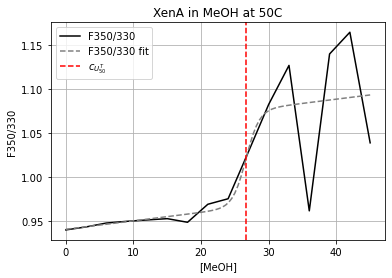

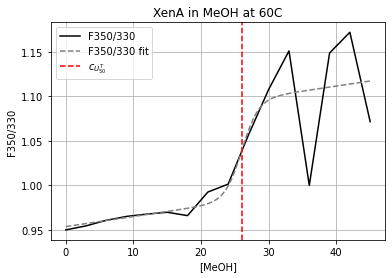

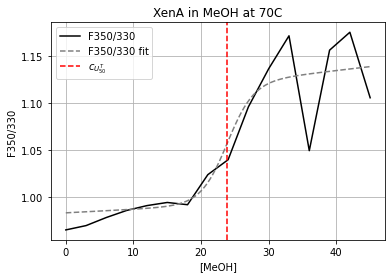

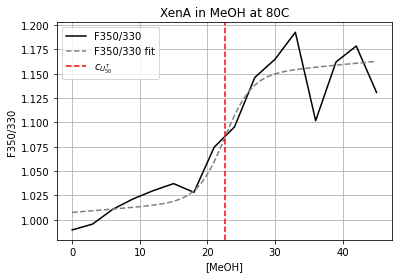

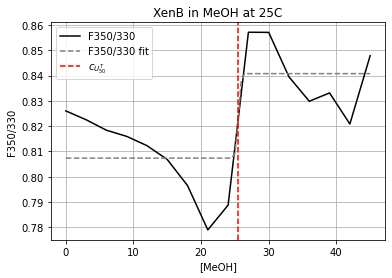

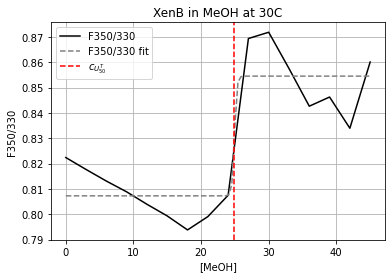

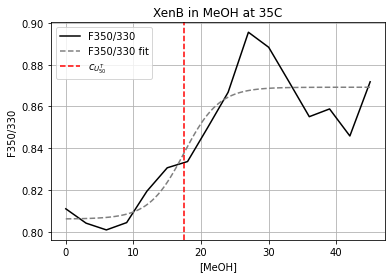

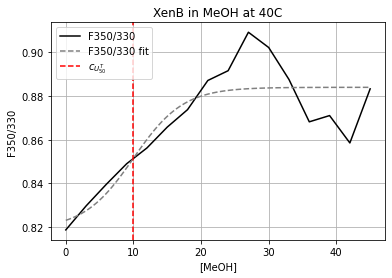

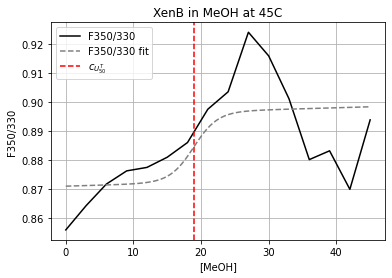

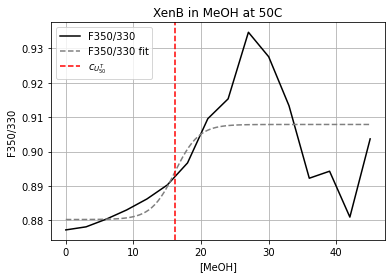

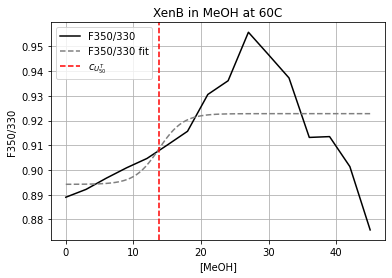

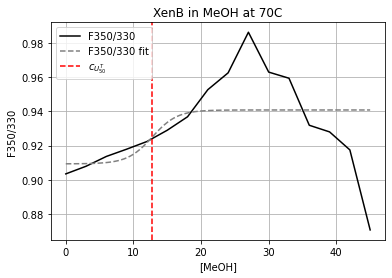

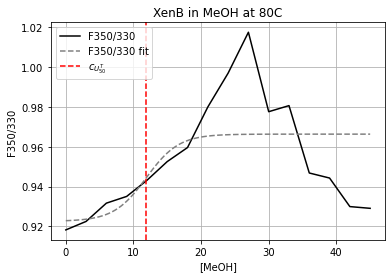

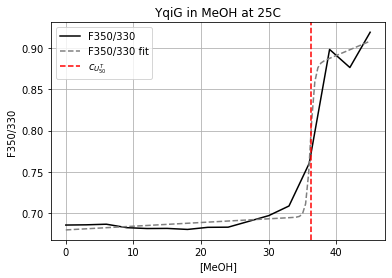

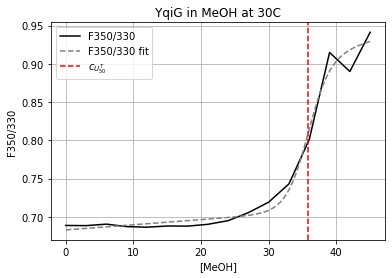

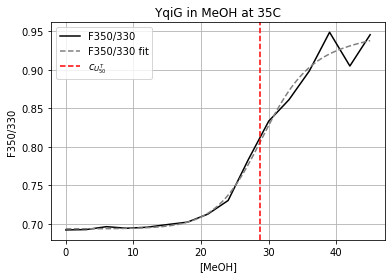

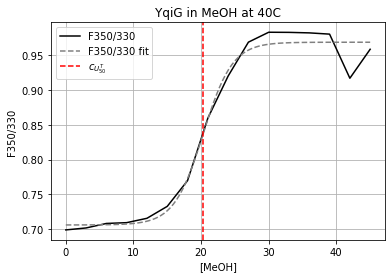

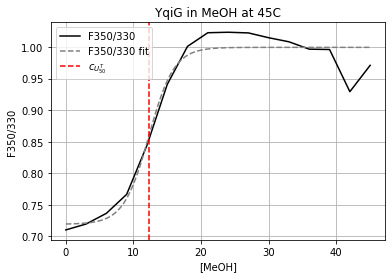

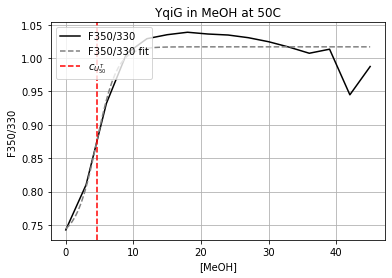

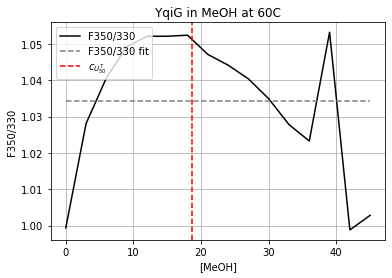

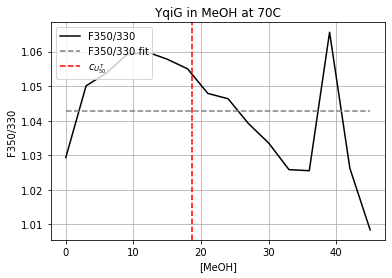

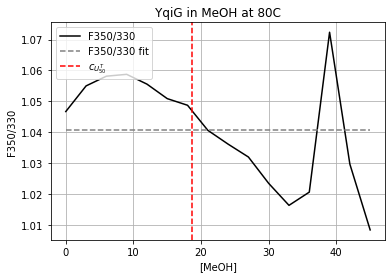

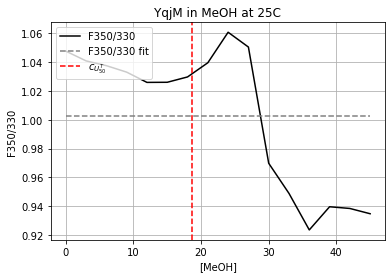

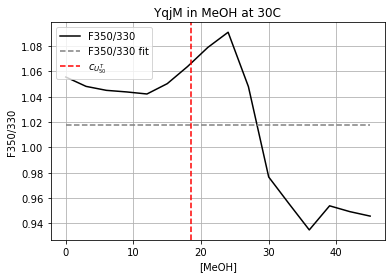

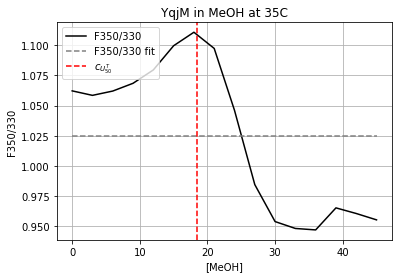

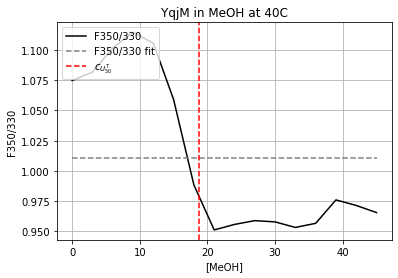

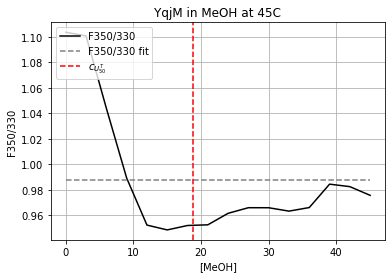

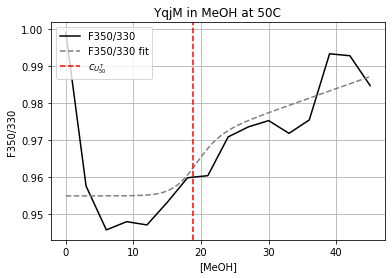

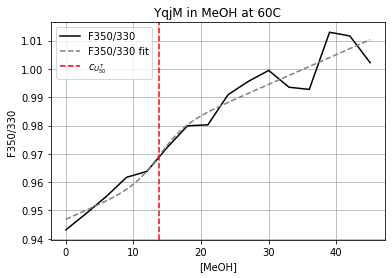

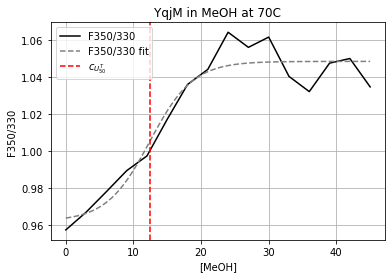

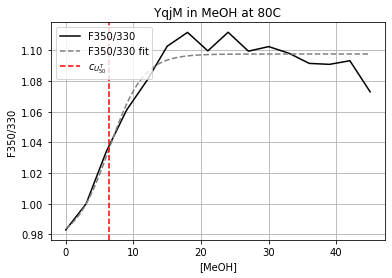

aN        bN        aD        bD  \
Solvent Enzyme  Temperature                                           
EtOH    ChrOYE1 25           0.583996  0.001919  0.127719  0.003044   
                30           0.593206  0.003006  0.183047  0.000672   
                35           0.624684  0.004257  0.155805  0.000000   
                40           0.673520  0.001864  0.201674  0.000000   
                45           0.727915  0.001753  0.162783  0.000000   
...                               ...       ...       ...       ...   
MeOH    YqjM    45           0.988012  0.000000  0.000000  0.000000   
                50           0.955007  0.000000  0.003078  0.000648   
                60           0.946861  0.001050  0.016183  0.000000   
                70           0.961911  0.000000  0.086522  0.000000   
                80           0.974934  0.000000  0.122734  0.000000   

                                       m        D50  
Solvent Enzyme  Temperature                          
EtOH    ChrOYE1 25           4389.419941  27.430484  
                30           2161.521191  27.047984  
                35           1342.681906  22.805943  
                40           1153.965916  13.212531  
                45           1523.197270   7.510643  
...                                  ...        ...  
MeOH    YqjM    45           1496.900104  18.787590  
                50           1496.512240  18.844082  
                60           1439.510300  13.851220  
                70            890.761330  12.428816  
                80           1166.653621   6.440445  

[234 rows x 6 columns]

In [3]:
PARAMETERS = [
    # name, λ, starting, bounds, scaling
    ('aN',   0,      7,       (0, None),      1/10),
    ('bN',   0,      1,       (0.0, None),  1/1000),
    ('aD',   0,      2,       (0, None),      1/10),
    ('bD',   0,      1,       (0.0, None),  1/1000),
    ('m',    0,      15,      (0, None),       100),
    ('D50',  0,      19,      (0, 100),          1),
]

# parameter_names
parameter_names = [n for n, _, _, _, _ in PARAMETERS]

# regularization coefficients
λ = np.array([l for _, l, _, _, _ in PARAMETERS])

# starting parameters
θ0 = [v for _, _, v, _, _ in PARAMETERS]

# parameter boundaries
bounds = [b for _, _, _, b, _ in PARAMETERS]

# parameter boundaries
scaling = [s for _, _, _, _, s in PARAMETERS]


def model(x, temp, params):
    aN, bN, aD, bD, m, D50 = params
    
    k = m * scaling[4] / (8.314 * temp)
    
    return (
        (aN * scaling[0] + bN * scaling[1] * x) + 
        (aD * scaling[2] + bD * scaling[3] * x) * 
        np.exp(k * (x-D50 * scaling[5])) /
        (1 + np.exp(k * (x-D50 * scaling[5])))
    )

def cost_function(params, x, y, temp):
    least_squares_cost = np.sum( (y - model(x, temp, params)) ** 2)
    regularization_cost = np.sum( (λ * params) ** 2)
    
    return least_squares_cost + regularization_cost


fit_parameters = []
for i, ((solvent, enzyme, temperature), dfg) in enumerate(tqdm(df.groupby(['Solvent', 'Enzyme', 'Temperature'], observed=True))):
    dfg = dfg.sort_values('Concentration')
    x = dfg['Concentration']
    y = dfg['FU']
    temp = temperature + 273
    
    θ = minimize(
        cost_function,
        θ0,                # starting values
        args=(x, y, temp), # data points
        bounds=bounds,     # boundaries for values
    )
    
    fit_parameters.append((solvent, enzyme, temperature, *θ.x))

    plt.figure(i)
    plt.title(f'{enzyme} in {solvent} at {temperature}C')
    plt.xlabel(f'[{solvent}]')
    plt.ylabel('F350/330')

    # plot data
    plt.plot(x, y, color='black', label='F350/330')

    # plot fits
    aN, bN, aD, bD, m, D50 = θ.x
    xrange = np.linspace(np.min(x), np.max(x), 100)
    yhat = model(xrange, temp, θ.x)
    
    plt.plot(xrange, yhat, ls='--', color='gray', label='F350/330 fit')
    plt.axvline(x=D50, ls='--', color='red', label='$c_{U^T_{50}}$')
    plt.legend(loc='upper left')
    plt.grid()
    plt.show()
    plt.close()

df_fits = pd.DataFrame.from_records(fit_parameters, columns=('Solvent', 'Enzyme', 'Temperature', *parameter_names))
df_fits.set_index(['Solvent', 'Enzyme', 'Temperature'], inplace=True)

# Convert scaled values back to actual values and modify scaling variable accordingly
for s, column in zip(scaling, df_fits.columns):
    df_fits[column] = df_fits[column]*s

# Save out fitted variables
df_fits.to_csv(f'{curpathout}/Unfolding_params.csv', index=True)

df_fits